In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [11]:

ticker= (
"BTCUSD"  
)

exportPath = './export/'
marketPath = './market/'
imgPath = './image/'
tmpPath = './tmp/'

if not os.path.exists(exportPath):
    os.makedirs(exportPath)
if not os.path.exists(marketPath):
    os.makedirs(marketPath)
if not os.path.exists(imgPath):
    os.makedirs(imgPath)
if not os.path.exists(tmpPath):
    os.makedirs(tmpPath)



_df = pd.read_csv(marketPath + ticker + '.csv',parse_dates = True,index_col=0)
# _df['y'] = _df[["open", "high", "low", "close"]].sum(axis=1).div(4) # (o+h+l+c)/4

_df = _df.resample('D').mean()


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

earliest = _df.iloc[:1].index
earliest = earliest.strftime('%Y-%m-%d')[0]

latest = _df.iloc[-1:].index
latest = latest.strftime('%Y-%m-%d')[0]

print(earliest, latest)

start_date = "2011-01-01"
end_date = latest

after_start_date = _df.index >= start_date
before_end_date = _df.index <= end_date
between_two_dates = after_start_date & before_end_date
_df = _df.loc[between_two_dates]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


_df['y'] = _df[["close"]]

# _df = log_transform(_df)
# _df = min_max_scaling(_df)


2009-10-05 2024-03-08


2024-03-08 00:00:00
2024-03-09 00:00:00
 Tomorrow Up Chance: 28.57 %
proportion_up: 0.2857142857142857
likely_up: 0


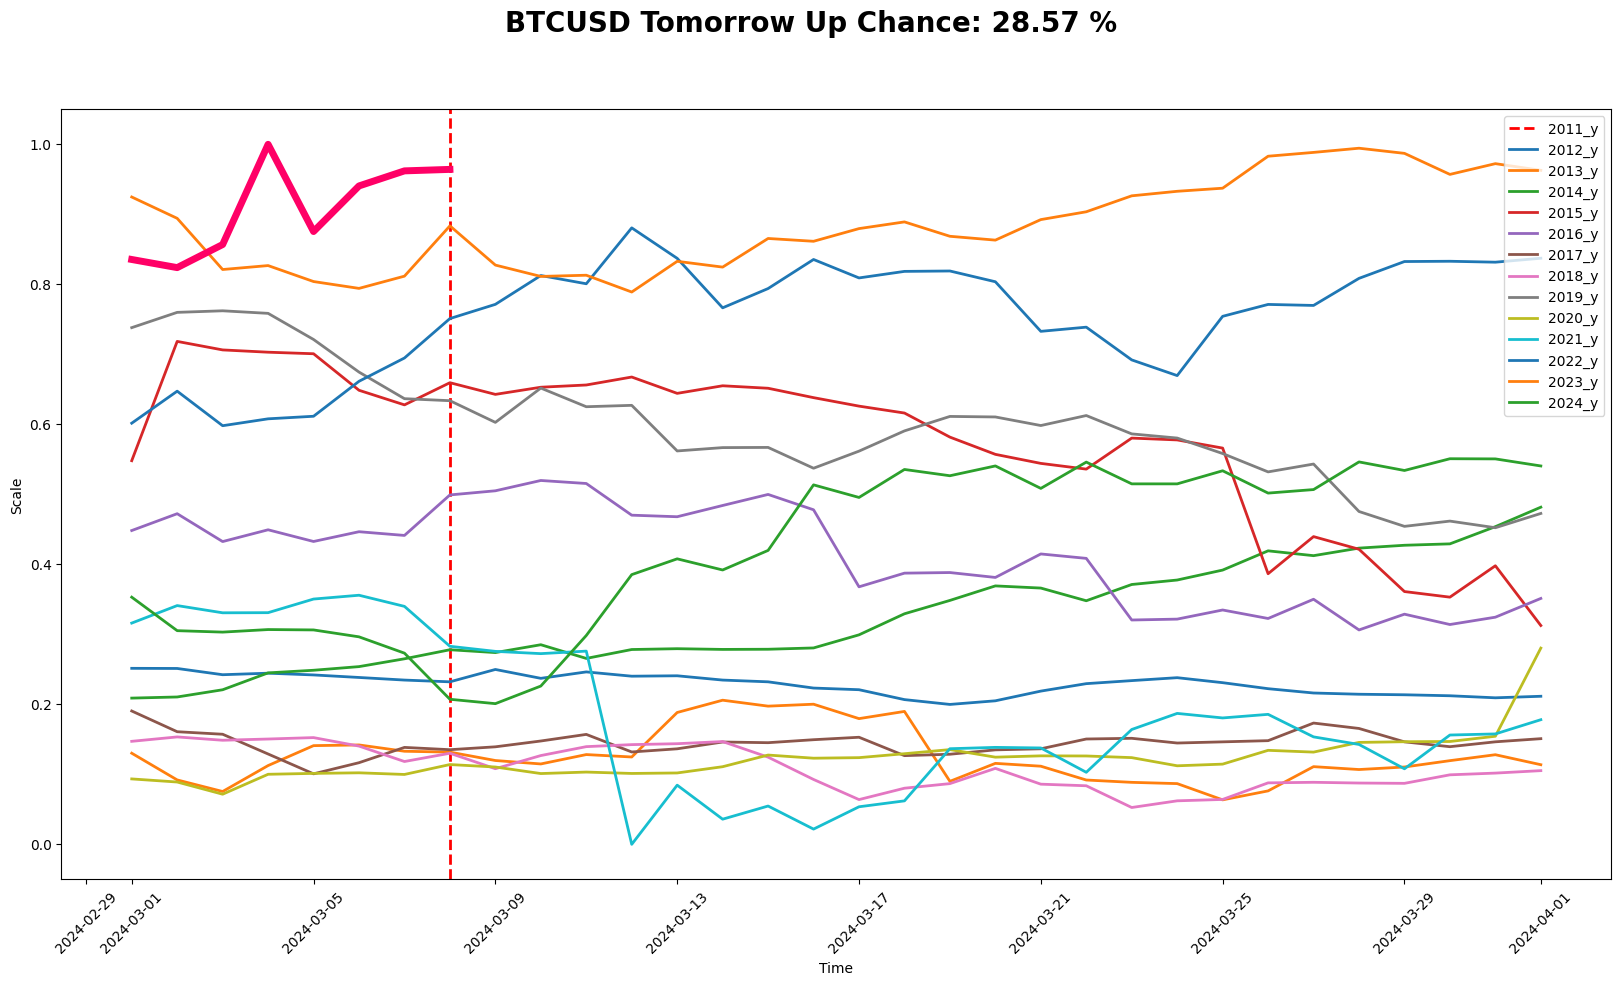

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime

# Load your time series data into a pandas DataFrame
df = _df['y'].to_frame()

# Extract the year from the index and add it as a new column
df['year'] = df.index.year

# Split the DataFrame into separate DataFrames for each year
df_list = [group[1].reset_index(drop=True) for group in df.groupby('year')]

# Rename the column in each DataFrame to include the year
for year_df in df_list:
    year = year_df['year'].iloc[0]
    year_df.rename(columns={'y': f"{year}_y"}, inplace=True)

# Concatenate the separate DataFrames into a single DataFrame
df_concat = pd.concat(df_list, axis=1)

# Apply log transformation to df_concat
df_concat = np.log(df_concat)

# Apply min-max scaling to df_concat
scaler = MinMaxScaler()
df_concat_scaled = scaler.fit_transform(df_concat)
df_concat_scaled = pd.DataFrame(df_concat_scaled, columns=df_concat.columns)

df_concat_scaled = df_concat_scaled.filter(regex='^(?!.*year).*$')


base = datetime.datetime(2024,1,1)
df_concat_scaled['timestamp'] = list(map(lambda x: base + datetime.timedelta(days=x), range(len(df_concat_scaled))))
df_concat_scaled = df_concat_scaled.set_index('timestamp', drop=True)

# Select rows between two dates using integer indexing
start_date = pd.Timestamp('2024-03-01')
end_date = pd.Timestamp('2024-04-01')
start_index = df_concat_scaled.index.get_loc(start_date)
end_index = df_concat_scaled.index.get_loc(end_date)
df_concat_scaled = df_concat_scaled.iloc[start_index:end_index+1]

# Plot the resulting DataFrame
fig, ax = plt.subplots(figsize=(20,10))

#--------------------------------------------------
# Find the last x-value in _df['y']
last_x = df_concat_scaled['2024_y'].last_valid_index()
print(last_x)
# Add a vertical line at the last x-value
ax.axvline(x=last_x, linewidth=2, color='red', linestyle='--')
#--------------------------------------------------
zdf = df_concat_scaled

# Calculate the flag for each column
flag_cols = []
for col in zdf.columns:
    if col not in ['up_down', 'avg_prob']:
        flag_col = (zdf[col] > zdf[col].shift(1)).fillna(0).astype(int)
        flag_cols.append(flag_col)

# Create a new dataframe containing the flag columns
flags_df = pd.concat(flag_cols, axis=1)

# Calculate the proportion of "up" flags for each row
flags_df['proportion_up'] = flags_df.mean(axis=1)

# Set a threshold value
threshold = 0.5

# Create a new column indicating whether each row is likely to go up or down
flags_df['likely_up'] = (flags_df['proportion_up'] > threshold).astype(int)
# print(flags_df)
# Find the row index of last_x in the flags_df dataframe
# last_x_index = flags_df['2024_y'].last_valid_index() 
last_x_index = last_x + pd.DateOffset(days=1)
print(last_x_index)
# Retrieve the values of proportion_up and likely_up at last_x_index
proportion_up = flags_df.loc[last_x_index, 'proportion_up']
likely_up = flags_df.loc[last_x_index, 'likely_up']
chance = ' Tomorrow Up Chance: ' + str(round(proportion_up * 100,2)) + ' %'
print(chance)
# Print the values
print("proportion_up:", proportion_up)
print("likely_up:", likely_up)

#--------------------------------------------------

import matplotlib.dates as mdates
# Set a title for the entire figure
title = ticker + chance
fig.suptitle(title, fontsize=20, fontweight="bold")

# Set Major Locator separately
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# Set Major Formatter with desired format string
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_ylabel('Scale', color='black')
ax.set_xlabel('Time', color='black')
plt.xticks(rotation=45)  # Rotate 45 degrees

ax.plot(df_concat_scaled, linewidth=2)
ax.plot(df_concat_scaled.index, df_concat_scaled['2024_y'], linewidth=5, color='#ff0066', label='2023_y')

# Add a legend for each line in the plot
ax.legend(df_concat_scaled.columns)
plt.savefig(imgPath + ticker + 'chance', dpi=300, bbox_inches='tight')

plt.show()


